# **Redes Neurais**
## **Modelo 3 - Variational Autoencoder (VAE)**

- Aluno: Tales Miguel
- RA: 140247

- Professor Dr. Marcos G. Quiles

## **Instruções**

▸Selecionar 2 datasets (rotulados) -----> Se for um relatório detalhado, pode usar apenas 1 dataset

▸Treinar modelos VAEs:
  - Ajustar o melhor modelo (topologia) segundo a função de custo (conjunto validação)

▸Explorar o espaço latente:
  - Gerar gráficos com a projeção do espaço latente em 2D (PCA)
  - Usar os rótulos na projeção

▸Algumas questões:
  1. Há formação de clusters no espaço latente?
  2. Há separação dos rótulos no espaço latente?
  3. A projeção ilustra quanto da variância?

▸ Adicional (opcional): Enviesar a formação do espaço latente com os exemplos rotulados

## **1. Escolha do Dataset e Pré-processamento dos dados**

### **1.1. Dataset Escolhido - EMNIST Letters**

**Dataset**: EMNIST Letters  
**Fonte**: Extended MNIST (Cohen et al., 2017) | [Acesso via TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/emnist)

**Características:**
- **Samples**: ~145.000 imagens (124.800 treino + 20.800 teste)
- **Dimensões**: 28x28 pixels (grayscale)
- **Features**: 784 (28×28 pixels normalizados)
- **Classes**: 26 letras maiúsculas (A-Z)

### **1.2. Imports e Pré-processamento**

In [5]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

np.random.seed(42)
tf.random.set_seed(42)

In [7]:
dataset, info = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset

x_train_list, y_train_list = [], []
for image, label in tfds.as_numpy(train_dataset):
    x_train_list.append(image)
    y_train_list.append(label)

x_test_list, y_test_list = [], []
for image, label in tfds.as_numpy(test_dataset):
    x_test_list.append(image)
    y_test_list.append(label)

x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
x_test = np.array(x_test_list)
y_test = np.array(y_test_list)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

y_train = y_train - 1
y_test = y_test - 1

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")
print(f"Pixel range: [{x_train.min():.1f}, {x_train.max():.1f}]")
print(f"Classes: {np.unique(y_train)} (0=A, 25=Z)")
print(f"Total de samples: {len(x_train) + len(x_val) + len(x_test)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.0W9SE6_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.0W9SE6_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.
Train: (71040, 28, 28), Val: (17760, 28, 28), Test: (14800, 28, 28)
Pixel range: [0.0, 1.0]
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] (0=A, 25=Z)
Total de samples: 103600


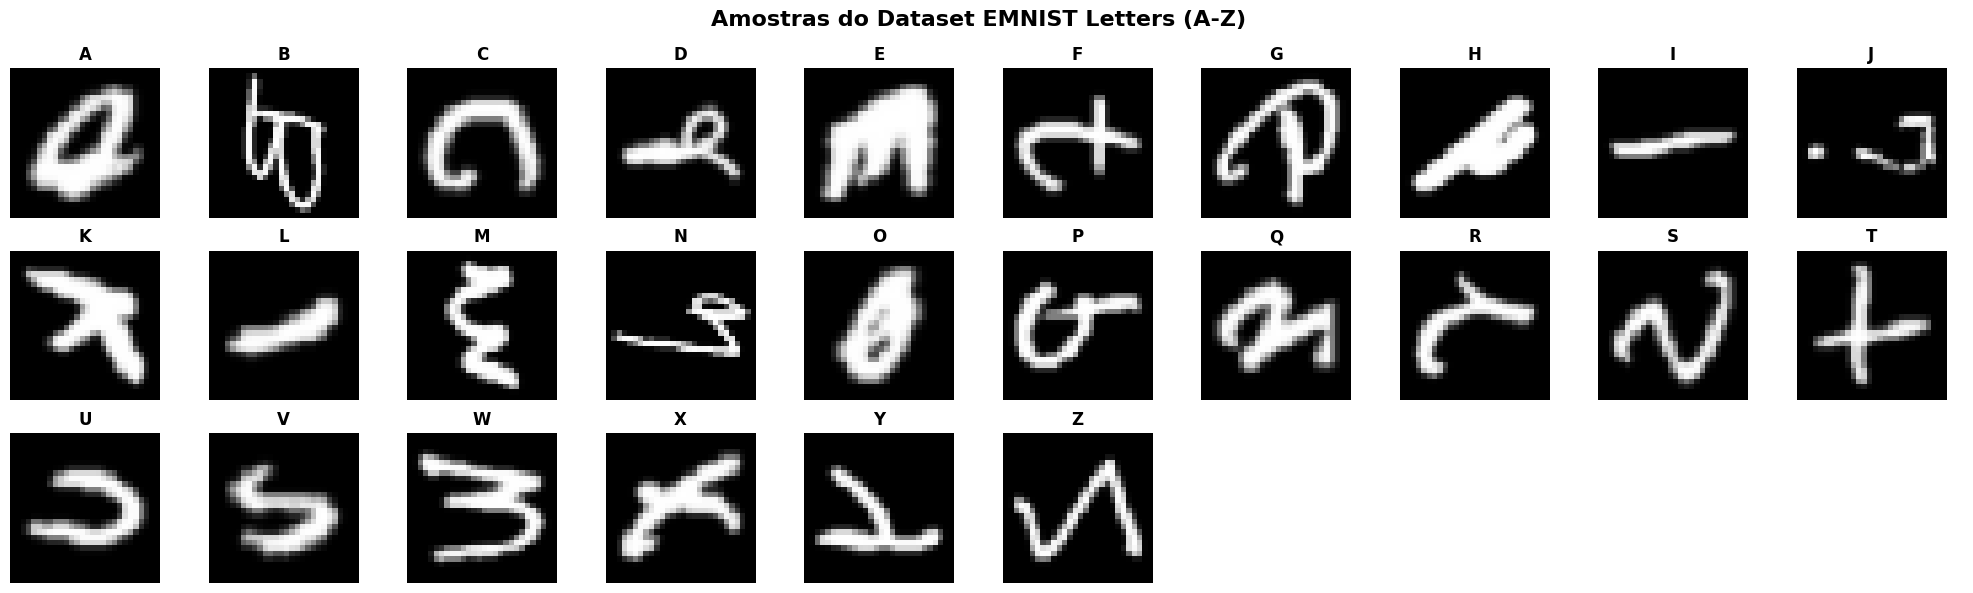

In [8]:
letter_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

fig, axes = plt.subplots(3, 10, figsize=(20, 6))
axes = axes.ravel()

for i in range(26):
    idx = np.where(y_train == i)[0][0]
    img = x_train[idx]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{letter_names[i]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

for i in range(26, 30):
    axes[i].axis('off')

plt.suptitle('Amostras do Dataset EMNIST Letters (A-Z)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### **2.1. Configuração das Topologias para Experimentos**

In [10]:
def build_encoder(latent_dim, encoder_layers):
    encoder_inputs = keras.Input(shape=(28, 28))
    x = layers.Flatten()(encoder_inputs)

    for units in encoder_layers:
        x = layers.Dense(units, activation='relu')(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

def build_decoder(latent_dim, decoder_layers):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = latent_inputs

    for units in decoder_layers:
        x = layers.Dense(units, activation='relu')(x)

    decoder_outputs = layers.Dense(784, activation='sigmoid')(x)
    decoder_outputs = layers.Reshape((28, 28))(decoder_outputs)

    decoder = Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder

In [12]:
topologies = [
    {
        'name': '2 camadas, 512-256',
        'latent_dim': 16,
        'encoder_layers': [512, 256],
        'decoder_layers': [256, 512]
    },
    {
        'name': '3 camadas, 512-256-128',
        'latent_dim': 16,
        'encoder_layers': [512, 256, 128],
        'decoder_layers': [128, 256, 512]
    },
    {
        'name': '3 camadas, 256-128-64',
        'latent_dim': 16,
        'encoder_layers': [256, 128, 64],
        'decoder_layers': [64, 128, 256]
    },
    {
        'name': '4 camadas, 512-256-128-64',
        'latent_dim': 16,
        'encoder_layers': [512, 256, 128, 64],
        'decoder_layers': [64, 128, 256, 512]
    },
    {
        'name': '2 camadas, 512-256, latent=32',
        'latent_dim': 32,
        'encoder_layers': [512, 256],
        'decoder_layers': [256, 512]
    }
]

In [13]:
import os

results_file = 'vae_results.pkl'

if os.path.exists(results_file):
    print("Arquivo de resultados encontrado! Carregando...")
    with open(results_file, 'rb') as f:
        results = pickle.load(f)

In [15]:
best_idx = np.argmin([r['history']['val_total_loss'][-1] for r in results])
best_model = results[best_idx]

print(f"\nMelhor topologia: {best_model['name']}")
print(f"Loss final (validação): {best_model['history']['val_total_loss'][-1]:.4f}")
print(f"Reconstruction Loss: {best_model['history']['val_reconstruction_loss'][-1]:.4f}")
print(f"KL Loss: {best_model['history']['val_kl_loss'][-1]:.4f}")


Melhor topologia: 2 camadas, 512-256
Loss final (validação): 9.8397
Reconstruction Loss: 9.6731
KL Loss: 0.1666


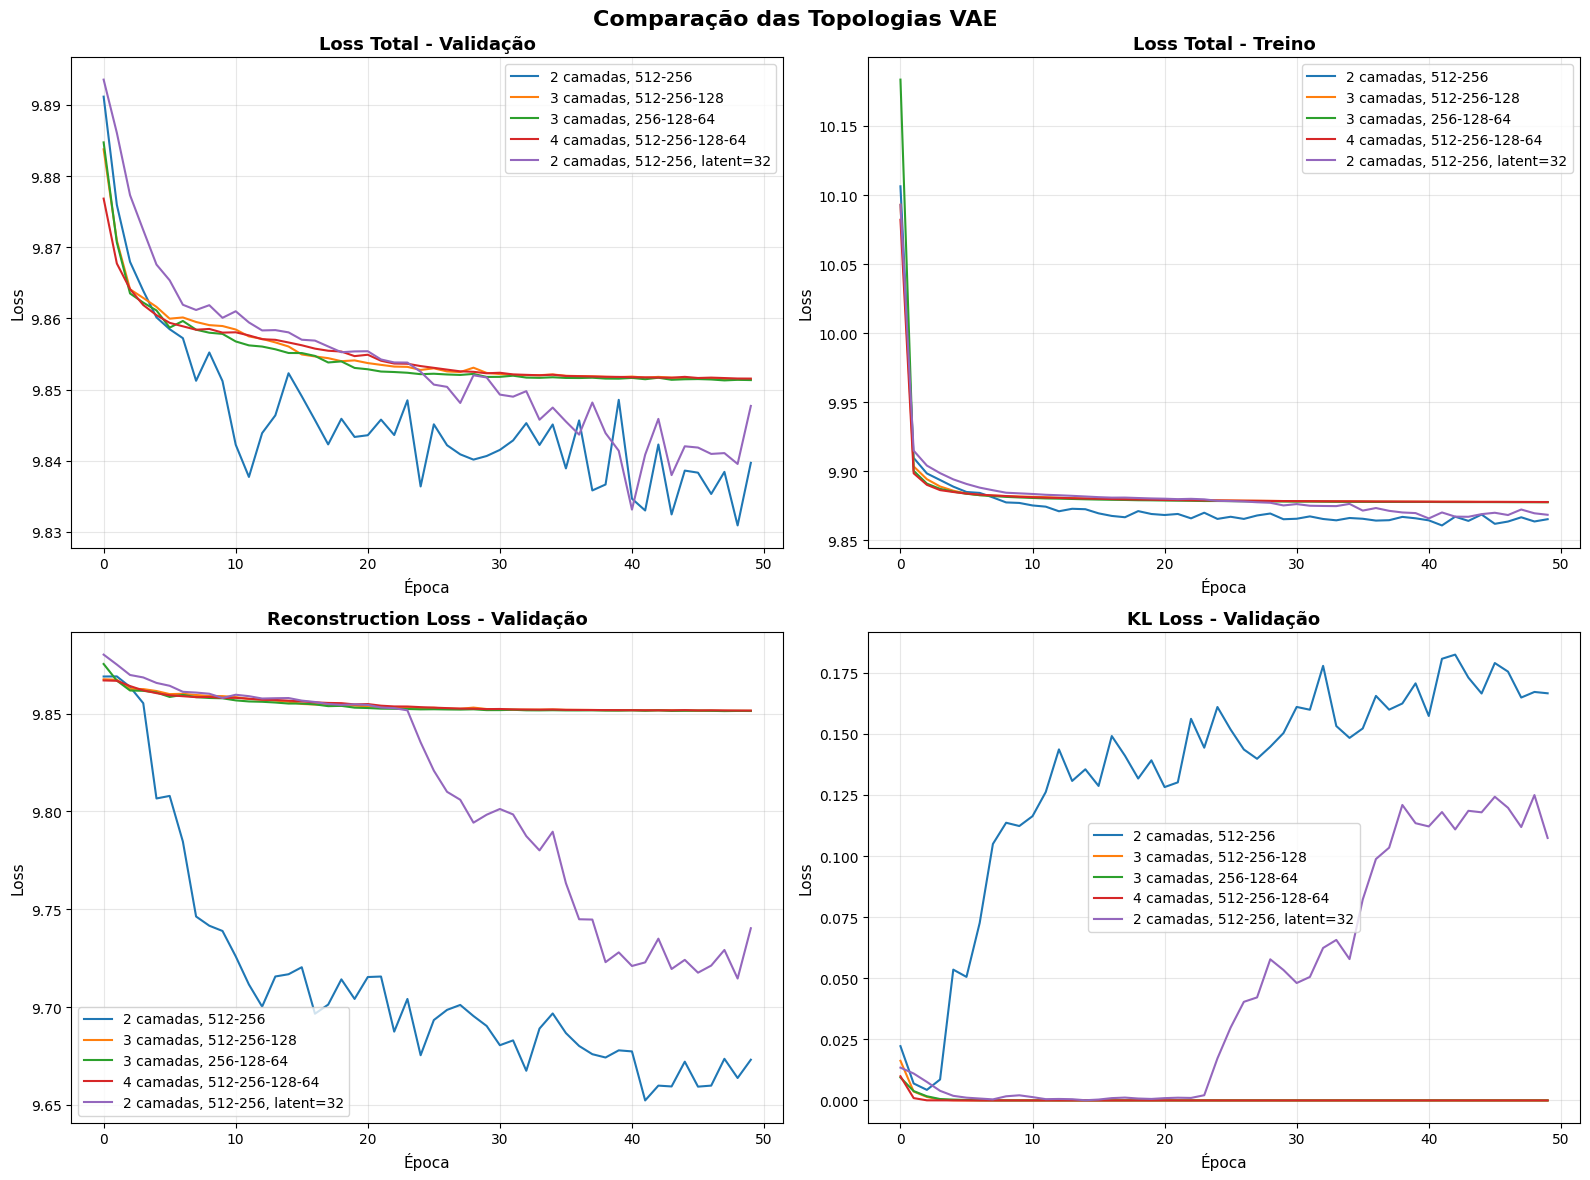

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].set_title('Loss Total - Validação', fontsize=13, fontweight='bold')
for r in results:
    axes[0, 0].plot(r['history']['val_total_loss'], label=r['name'])
axes[0, 0].set_xlabel('Época', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('Loss Total - Treino', fontsize=13, fontweight='bold')
for r in results:
    axes[0, 1].plot(r['history']['total_loss'], label=r['name'])
axes[0, 1].set_xlabel('Época', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title('Reconstruction Loss - Validação', fontsize=13, fontweight='bold')
for r in results:
    axes[1, 0].plot(r['history']['val_reconstruction_loss'], label=r['name'])
axes[1, 0].set_xlabel('Época', fontsize=11)
axes[1, 0].set_ylabel('Loss', fontsize=11)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('KL Loss - Validação', fontsize=13, fontweight='bold')
for r in results:
    axes[1, 1].plot(r['history']['val_kl_loss'], label=r['name'])
axes[1, 1].set_xlabel('Época', fontsize=11)
axes[1, 1].set_ylabel('Loss', fontsize=11)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Comparação das Topologias VAE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- Cinco topologias distintas, variando a profundidade da rede e a dimensionalidade do espaço latente.
- Otimizador ADAM em todas
- Learning rate = 0.001
- Batch size de 128
- Treinadas por 50 épocas
- A função de perda combina binary crossentropy com KL divergence
- A melhor topologia foi selecionada com base no menor loss total no conjunto de validação.

### **3.1. Projeção do Espaço Latente em 2D (PCA)**

### **3.3. Questão 2: Há Separação dos Rótulos no Espaço Latente?**

### **3.5. Interpolação no Espaço Latente**

## **4. Avaliação Final e Conclusões**

### **4.2. Síntese dos Resultados e Conclusões**